In [41]:
import pandas as pd
import Seeker
matching_results = pd.read_csv('input/snw0501_maxmatch.csv')
matching_results = pd.read_csv('input/snw0501_detour_case12.csv')
orders = pd.read_csv('input/order.csv')
shortest_path = pd.read_csv('input/shortest_path.csv')
matching_detour = pd.read_csv('input/snw0501_detour.csv')
matching_detour = pd.read_csv('input/snw0501_detour_case12.csv')



In [2]:
orders.head()

,Unnamed: 0,dwv_order_make_haikou_1.order_id,dwv_order_make_haikou_1.departure_time,O_location,D_location,OD_id,matching_prob,ride_distance,detour_distance,shared_distance,...,detour_distance_for_taker,shared_distance_for_taker,ride_distance_for_seeker,detour_distance_for_seeker,shared_distance_for_seeker,saved_distance_for_seeker,saved_distance_for_taker,origin_id,destination_id,lambda
0,0,17592367569051,2017-05-01 07:57:41,194.0,2400.0,137,0.999077,5281.560573,930.345312,3784.507952,...,1341.142542,3935.644858,4601.591031,250.375769,1789.105861,919.537859,1624.192157,194,2400,0.000566
1,1,17592368066368,2017-05-01 08:31:15,1078.0,3694.0,585,0.931964,17524.107064,982.993603,6728.184116,...,1252.575192,6916.646707,16945.008170,403.894709,3530.434003,2570.232918,5622.155143,1078,3694,0.000566
2,2,17592367714348,2017-05-01 08:11:03,2660.0,480.0,1379,0.994994,5592.991521,819.051442,3426.476123,...,1153.257098,3316.368057,5040.567602,266.627523,1837.896229,995.286139,1285.406318,2660,480,0.000566
3,3,17592367767705,2017-05-01 08:20:19,2245.0,194.0,1245,0.999391,9994.997951,1283.543040,5154.418464,...,1371.871610,5170.195050,9201.336451,489.881540,2163.333344,1115.558032,3464.114520,2245,194,0.000566
4,4,17592367873770,2017-05-01 08:22:00,3033.0,824.0,1424,0.851976,9158.236283,737.747785,4105.192425,...,839.816766,3508.161999,8420.488498,0.000000,1023.402626,907.139581,1827.126200,3033,824,0.000566


In [11]:
for index,row in matching_results.iterrows():
    print(row[0],row[1])

1 1309
2 317
3 806
4 866
5 551
6 1220
7 979
8 54
9 977
10 1517
11 1546
12 538
13 100
14 303
15 1231
16 178
17 229
18 1560
19 1425
20 1559
21 1278
22 1591
23 803
24 1420
25 1707
26 1429
27 1160
28 1695
29 1395
30 553
31 1324
32 445
33 591
34 727
35 1243
36 728
37 560
38 238
39 1019
40 1342
41 723
42 1347
43 1628
44 986
45 255
46 367
47 1109
48 926
49 1725
50 412
51 1281
52 476
53 1133
55 1460
56 1686
57 388
58 1716
59 1041
60 389
61 980
62 597
63 157
64 706
65 261
66 1743
67 743
68 1023
69 1163
70 473
71 1511
72 201
73 1689
74 1428
75 1535
76 579
77 286
78 1078
79 869
80 503
81 1346
82 1298
83 1659
84 1399
85 1731
86 1765
87 1755
88 372
89 1283
90 366
91 1730
92 595
93 1048
94 855
95 427
96 1453
97 1575
98 461
99 1718
101 1407
102 113
103 1412
104 289
105 156
106 331
107 1712
108 239
109 978
110 1318
111 811
112 1738
114 1314
115 675
116 873
117 1616
118 933
119 1447
120 1390
121 1322
122 1509
123 1551
124 900
125 687
126 858
127 1291
128 838
129 271
130 265
131 1615
132 1193
133 1654
1

In [12]:
print(len(matching_results),len(orders))

880 1766


In [42]:

import Network as net
from tqdm.notebook import tqdm_notebook

network = net.Network()
def is_fofo( p0, p1):
    fofo = [
        get_path(p1.O_location, p0.D_location),
        get_path(p0.D_location, p1.D_location)
    ]
    lofo = [
        get_path(p1.O_location, p1.D_location),
        get_path(p1.D_location, p0.D_location)
    ]
    if sum(fofo) < sum(lofo):
        return True, fofo
    else:
        return False, lofo


def get_path(O, D):
    tmp = shortest_path[(shortest_path['O'] == O) & (shortest_path['D'] == D)]
    if tmp['distance'].unique():
        return tmp['distance'].unique()[0]
    else:
        return network.get_path(O, D)[0]


Seekers = {}
for index, row in orders.iterrows():
    seeker = Seeker.Seeker(row)
    seeker.set_shortest_path(get_path(seeker.O_location, seeker.D_location))
    Seekers[index] = seeker


detour_distance = []
shared_distance = []
saved_distance = []

for index,row in tqdm_notebook(matching_results.iterrows(), total=len(matching_results), desc='Processing rows'):
    p0 = Seekers[row[0]]
    p1 = Seekers[row[1]]

    # 决定派送顺序，是否fofo
    fofo, distance = is_fofo(p0, p1)

    if fofo:
        p0_invehicle = distance[0] + get_path(p0.O_location,p1.O_location)
        p0_expected_distance = p0.shortest_distance

        p1_invehicle = sum(distance)
        p1_expected_distance = p1.shortest_distance

        # 绕行
        detour_distance.append(p0_invehicle - p0_expected_distance)
        detour_distance.append(p1_invehicle - p1_expected_distance)
        # 共乘
        shared_distance.append(distance[0])
        # 节省的里程
        saved_distance .append( p0_expected_distance + p1_expected_distance - (p0_invehicle + p1_invehicle - distance[0]))
    else:
        p0_invehicle = sum(distance) + get_path(p0.O_location,p1.O_location)
        p0_expected_distance = p0.shortest_distance

        p1_invehicle = distance[0]
        p1_expected_distance = p1.shortest_distance

        # 绕行
        detour_distance.append(p0_invehicle - p0_expected_distance)
        detour_distance.append(p1_invehicle - p1_expected_distance)
        # 共乘
        shared_distance.append(distance[0])
        # 节省的里程
        saved_distance .append( p0_expected_distance + p1_expected_distance - (p0_invehicle + p1_invehicle - distance[0]))



C:\Users\yangchen\AppData\Local\Temp\ipykernel_14056\494660188.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if tmp['distance'].unique():


Processing rows:   0%|          | 0/879 [00:00<?, ?it/s]

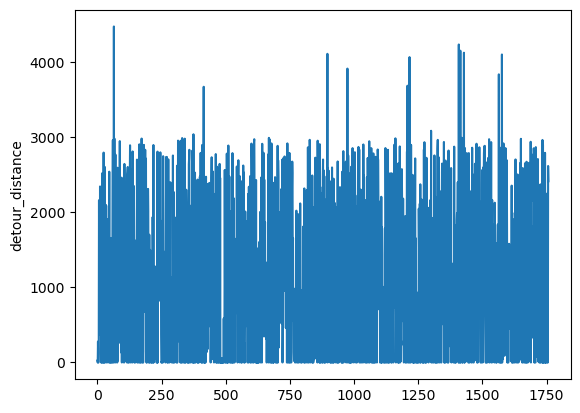

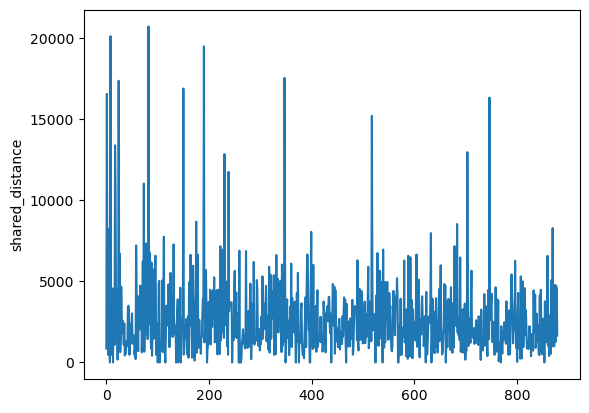

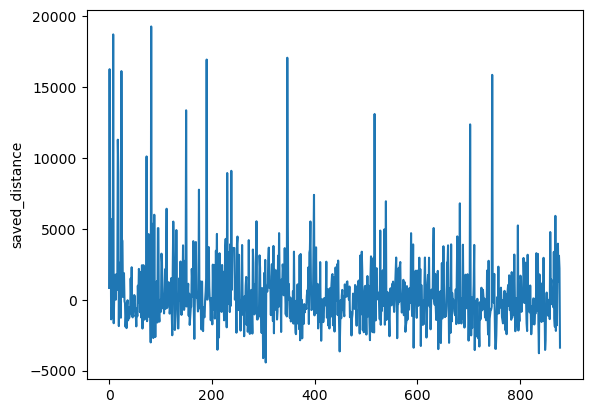

mean_detour:1115.2278449715352,mean_shared:2642.170975847655,total_saved:361897.73631013004


In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(detour_distance)
plt.ylabel('detour_distance')
plt.show()
plt.plot(shared_distance)
plt.ylabel('shared_distance')
plt.show()
plt.plot(saved_distance)
plt.ylabel('saved_distance')
plt.show()
print('mean_detour:{},mean_shared:{},total_saved:{}'.format(np.mean(detour_distance),np.mean(shared_distance),np.sum(saved_distance)))

In [31]:
import networkx as nx

#读街道数据，建图算最短路
edge=pd.read_csv('input/links.csv') 
#print(edge.dtypes)

G = nx.Graph()#无向图
edge_list=[]
for row in edge.index:
    weight=edge.loc[row]['length']
    h_vertex=edge.loc[row]['from_node_id']
    t_vertex=edge.loc[row]['to_node_id']
    edg=(h_vertex,t_vertex,weight)
    edge_list.append(edg)
G.add_weighted_edges_from(edge_list)

from tqdm.notebook import tqdm_notebook

network = net.Network()
def is_fofo( p0, p1):
    fofo = [
        get_path(p1.O_location, p0.D_location),
        get_path(p0.D_location, p1.D_location)
    ]
    lofo = [
        get_path(p1.O_location, p1.D_location),
        get_path(p1.D_location, p0.D_location)
    ]
    if sum(fofo) < sum(lofo):
        return True, fofo
    else:
        return False, lofo


def get_path(O, D):
    return nx.dijkstra_path_length(G, source=O, target=D)


Seekers = {}
for index, row in orders.iterrows():
    seeker = Seeker.Seeker(row)
    seeker.set_shortest_path(get_path(seeker.O_location, seeker.D_location))
    Seekers[index] = seeker






Processing rows:   0%|          | 0/880 [00:00<?, ?it/s]

In [33]:
detour_distance = []
p0_detour_dic = {}
p1_detour_dic = {}
shared_distance = []
saved_distance = []

for index,row in tqdm_notebook(matching_results.iterrows(), total=len(matching_results), desc='Processing rows'):
    p0 = Seekers[row[0]]
    p1 = Seekers[row[1]]

    # 决定派送顺序，是否fofo
    fofo, distance = is_fofo(p0, p1)

    if fofo:
        p0_invehicle = distance[0] + get_path(p0.O_location,p1.O_location)
        p0_expected_distance = p0.shortest_distance

        p1_invehicle = sum(distance)
        p1_expected_distance = p1.shortest_distance

        # 绕行
        detour_distance.append(p0_invehicle - p0_expected_distance)
        detour_distance.append(p1_invehicle - p1_expected_distance)
        p0_detour_dic[index] = p0_invehicle - p0_expected_distance
        p1_detour_dic[index] = p1_invehicle - p1_expected_distance
        # 共乘
        shared_distance.append(distance[0])
        # 节省的里程
        saved_distance .append( p0_expected_distance + p1_expected_distance - (p0_invehicle + p1_invehicle - distance[0]))
    else:
        p0_invehicle = sum(distance) + get_path(p0.O_location,p1.O_location)
        p0_expected_distance = p0.shortest_distance

        p1_invehicle = distance[0]
        p1_expected_distance = p1.shortest_distance

        # 绕行
        detour_distance.append(p0_invehicle - p0_expected_distance)
        detour_distance.append(p1_invehicle - p1_expected_distance)
        p0_detour_dic[index] = p0_invehicle - p0_expected_distance
        p1_detour_dic[index] = p1_invehicle - p1_expected_distance
        # 共乘
        shared_distance.append(distance[0])
        # 节省的里程
        saved_distance .append( p0_expected_distance + p1_expected_distance - (p0_invehicle + p1_invehicle - distance[0]))

Processing rows:   0%|          | 0/880 [00:00<?, ?it/s]

In [35]:
p0_detour_dic
p1_detour_dic

{0: 0.0,
 1: 2566.718050617251,
 2: 1671.6133383026945,
 3: 1121.4628443307424,
 4: 2645.3039779924147,
 5: 329.96253642118745,
 6: 274.7770193163051,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 2537.555588164678,
 12: 1384.7881061809167,
 13: 0.0,
 14: 95.44472139049958,
 15: 986.3953138883444,
 16: 0.0,
 17: 2628.165047576682,
 18: 0.0,
 19: 0.0,
 20: 772.5782235273437,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: -1.8189894035458565e-12,
 27: 1679.0550388720394,
 28: -9.094947017729282e-13,
 29: 2013.7845290004307,
 30: 0.0,
 31: 0.0,
 32: 1216.6333520455478,
 33: 0.0,
 34: 1806.294202217241,
 35: 0.0,
 36: 1785.6234521932165,
 37: 1935.6416069590914,
 38: 164.17846936264505,
 39: 0.0,
 40: 2793.6103520674988,
 41: 153.46751944218795,
 42: 1269.222724470334,
 43: 0.0,
 44: 0.0,
 45: 1824.459333327526,
 46: 2126.2621432518613,
 47: 62.53469302868143,
 48: 0.0,
 49: 2174.5690340558804,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 12.091313847222409,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.

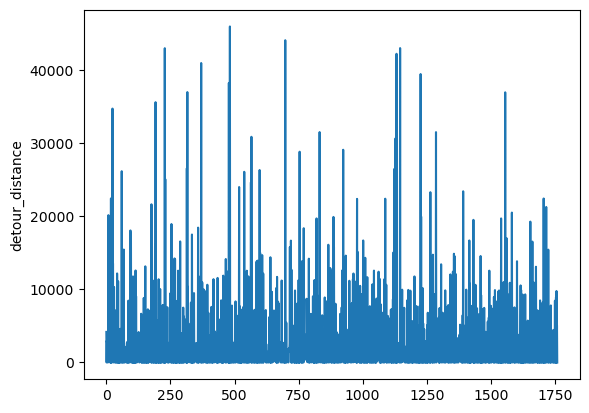

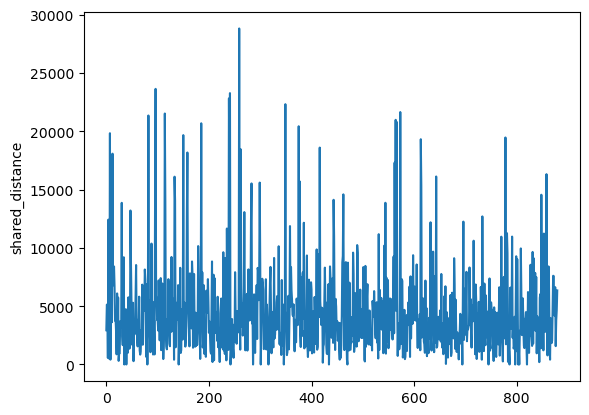

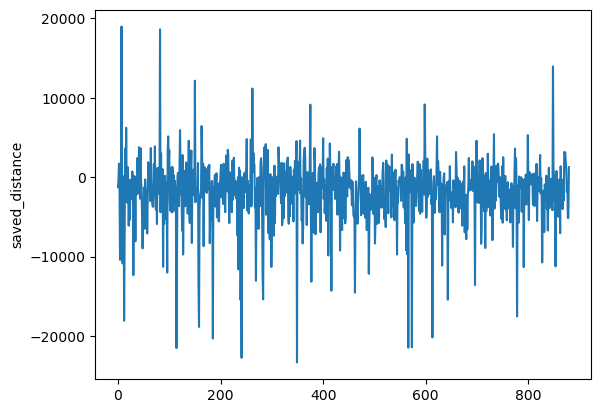

mean_detour:3179.2193031940537,mean_shared:4495.977975992943,total_saved:-1638965.3547477447


In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(detour_distance)
plt.ylabel('detour_distance')
plt.show()
plt.plot(shared_distance)
plt.ylabel('shared_distance')
plt.show()
plt.plot(saved_distance)
plt.ylabel('saved_distance')
plt.show()
print('mean_detour:{},mean_shared:{},total_saved:{}'.format(np.mean(detour_distance),np.mean(shared_distance),np.sum(saved_distance)))

In [39]:
print(matching_detour.columns)
matching_detour.groupby(['case '])['i_detour'].count()

Index(['i', 'j', 'i_detour', 'j_detour', 'case '], dtype='object')


case 
1    381
2     70
3    380
4     50
Name: i_detour, dtype: int64